# 패키지 설치

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 19.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [ ]:
!pip install librosa

In [ ]:
!pip install pydub

In [ ]:
!apt-get install ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
# !pip install noisereduce

In [ ]:
!pip install torchaudio

In [ ]:
# !pip install pyAudioAnalysis

In [ ]:
# !pip install hmmlearn

# IMPORT

In [ ]:
import librosa

from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import random

from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import torch
import torchmetrics
import os

import matplotlib.pyplot as plt

import IPython.display as ipd
import librosa
import librosa.display as dsp
# from pydub import AudioSegment
# import noisereduce as nr
# import soundfile as sf
# import torchaudio

In [ ]:
# 코랩
from google.colab import drive
drive.mount('/content/drive')


# # 학교 컴
# from google.colab import files
# uploaded = files.upload()

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
print(torch.cuda.is_available())

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

True
cuda


# CONFIG

In [ ]:
class Config:

    SR = 16000 # 인간음성 영역

    N_MFCC = 20 # 도은님
    N_MELS = 128 # 인애님
    N_CHROMA = 12 # 12 가 기본음이므로 12로 설정

    # Dataset
    ROOT_FOLDER = '/content/drive/MyDrive/'

    # Training
    SPLIT_RATE = 0.37

    N_CLASSES = 2 # real, fake

    BATCH_SIZE = 64 # 보통 사이즈로 설정 [실험]

    N_EPOCHS = 30

    LR = 0.0001 # 학습률(Learning Rate, LR)로 보통 0.001~0.0001로 설정하여 진행

    # Others
    FEATURE = 'chroma'
    N = 12

    SEED = 42

    # sepctogram, mel_spectogram, mfcc 매개변수

    N_FFT = 1024  # FFT 크기, 주파수 해상도 설정
    WINDOW = 'hann'  # Hann 창 함수 사용
    HOP_LENGTH = 256  # 프레임 이동 거리, n_fft의 약 1/4 정도
    N_MELS = 128  # Mel 스펙트로그램에서의 Mel 필터 수
    WIN_LENGTH = N_FFT


CONFIG = Config()

# Fixed RandomSeed

- 아래의 코드는 머신러닝이나 딥러닝 모델을 훈련할 때, 결과의 재현성을 보장하기 위해 사용되는 함수입니다.
- 이 함수는 다양한 랜덤 시드를 고정하여, 실행할 때마다 동일한 결과를 얻기 위해 사용됩니다.

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CONFIG.SEED) # Seed 고정

In [ ]:
%pwd

'/content'

In [ ]:
# 데이터 저장된 상위 디렉토리로 이동
%cd /content/drive/MyDrive/
# # 학교 컴
# %cd C:\\Users\\swu\Downloads\open

/content/drive/MyDrive


In [ ]:
# !zip -r /content/drive/MyDrive/fake_fake.zip /content/drive/MyDrive/fake_fake_combined_output_final10
# !zip -r /content/drive/MyDrive/fake_real.zip /content/drive/MyDrive/fake_real_combined_output_final10
# !zip -r /content/drive/MyDrive/real_real.zip /content/drive/MyDrive/real_real_combined_output_final10

# Test Valid

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/train.csv') # train.csv 호출
train, val, _, _ = train_test_split(df, df['label'],
                                    test_size=CONFIG.SPLIT_RATE,
                                    random_state=CONFIG.SEED)
df.head()
test = pd.read_csv('/content/drive/MyDrive/test.csv') # test.csv 호출

df2 = pd.read_csv('/content/drive/MyDrive/unlabeled_data.csv')

def get_label_csv(df):
    labels = []
    for _, row in (df.iterrows()):
        # 라벨 저장
        label = row['label']
        label_vector = np.zeros(CONFIG.N_CLASSES, dtype=float)
        label_vector[0 if label == 'fake' else 1] = 1 # [0,1] , [1,0] 밖에 존재하지 않음
        labels.append(label_vector)
    return labels

train_labels = get_label_csv(train)
val_labels = get_label_csv(val)

In [ ]:
unlabeled_df = pd.read_csv('/content/drive/MyDrive/unlabeled_data.csv')

In [ ]:
# 피클 로드

import pickle

def load_features(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    # Ensure data is a numpy array # non_vector 는 다 길이가 달라서 np.array 로 받으면 안됨
    # if isinstance(data, list):
    #     data = np.array(data)
    return data

In [ ]:
# csv 로드

import csv

def read_csv_to_list(file_path):
    data = []
    with open(file_path, mode='r', newline='') as file:
        reader = csv.reader(file)
        for row in reader:
            # 각 행의 열 데이터를 실수로 변환하여 리스트에 저장
            data.append([float(value) for value in row])
    return np.array(data)

In [ ]:
import glob

# 파일 유실 없음
len(glob.glob('./unlabeled_data/*'))

1264

# 2차원 데이터 쓸거임

### zip 해제

In [ ]:
# def read_egg_file(egg_path):
#     with open(egg_path, 'rb') as f:
#         content = f.read(1024)  # 처음 1024 바이트만 읽어봅니다
#         print(content[:64])  # 처음 64 바이트만 출력하여 파일의 헤더를 확인

# # Example usage
# egg_path = '/content/drive/MyDrive/이화도인지/데이콘_가짜음성판별/original_data/features.egg'
# read_egg_file(egg_path)


In [ ]:
# import shutil

# def rename_egg_to_zip(egg_path, zip_path):
#     shutil.copy(egg_path, zip_path)
#     print(f"Renamed {egg_path} to {zip_path}")

# # Example usage
# egg_path = '/content/drive/MyDrive/이화도인지/데이콘_가짜음성판별/original_data/features.egg'
# zip_path = '/content/drive/MyDrive/이화도인지/데이콘_가짜음성판별/original_data/features.zip'
# rename_egg_to_zip(egg_path, zip_path)


In [ ]:
# import zipfile
# import os

# def extract_zip(zip_path, extract_to):
#     """
#     Extracts a zip file to a specified directory.

#     Parameters:
#     zip_path (str): The path to the zip file.
#     extract_to (str): The directory to extract the contents to.
#     """
#     try:
#         with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#             zip_ref.extractall(extract_to)
#         print(f"Files extracted to {extract_to}")
#     except Exception as e:
#         print(f"An error occurred: {e}")

# # Example usage
# zip_path = '/content/drive/MyDrive/이화도인지/데이콘_가짜음성판별/original_data/features.zip'
# extract_to = '/content/drive/MyDrive/이화도인지/데이콘_가짜음성판별/original_data/extracted'
# extract_zip(zip_path, extract_to)


An error occurred: File is not a zip file


### chroma original 불러오기

In [ ]:
train_chroma = load_features("/content/drive/MyDrive/이화도인지/데이콘_가짜음성판별/original_data/non_vector_train_chroma_n_chroma_12.pkl")
val_chroma = load_features("/content/drive/MyDrive/이화도인지/데이콘_가짜음성판별/original_data/non_vector_val_chroma_n_chroma_12.pkl")
unlabeled_chroma = load_features("/content/drive/MyDrive/이화도인지/데이콘_가짜음성판별/original_data/non_vector_unlabeled_chroma_n_chroma_12.pkl")
test_chroma = load_features("/content/drive/MyDrive/이화도인지/데이콘_가짜음성판별/original_data/non_vector_test_chroma_n_chroma_12.pkl")
ff_chroma = load_features("/content/drive/MyDrive/이화도인지/데이콘_가짜음성판별/original_data/fake_fake/non_vec_fake_fake_chroma_12.pkl")
fr_chroma = load_features("/content/drive/MyDrive/이화도인지/데이콘_가짜음성판별/original_data/fake_real/non_vec_fake_real_chroma_12.pkl")
rr_chroma = load_features("/content/drive/MyDrive/이화도인지/데이콘_가짜음성판별/original_data/real_real/non_vec_real_real_chroma_12.pkl")

# 패딩 ~~~~~

In [ ]:
def find_max(chroma):
    max_len = 0
    for i in chroma:
        if(len(i[0])>max_len):
            max_len = len(i[0])
    return max_len

max_len = find_max(train_chroma)
max_len = max(max_len, find_max(val_chroma))
max_len = max(max_len, find_max(unlabeled_chroma))
max_len = max(max_len, find_max(ff_chroma))
max_len = max(max_len, find_max(fr_chroma))
max_len = max(max_len, find_max(rr_chroma))

print(max_len)

1209


In [ ]:
def zero_pad(feature_list, max_y, to_extract_feature_file_path):
    zero_padded_feature_list = []

    for i in range(len(feature_list)):
        # 패딩 처리
        feature_map = feature_list[i]

        # 리스트 타입이면 NumPy 배열로 변환
        if isinstance(feature_map, list):
            feature_map = np.array(feature_map)


        # 디버깅: 원래 모양 출력
        # print(f"feature_map[{i}]의 원래 모양: {np.shape(feature_map)}")

        original_y = feature_map.shape[1]

        padding_size = max_y - original_y

        # 패딩 크기가 양수인지 확인
        if padding_size < 0:
            raise ValueError(f"Padding size cannot be negative. Original size: {original_y}, Max size: {max_y}")

        # 디버깅: 패딩 크기 출력
        # print(f"feature_map[{i}]의 패딩 크기: {padding_size}")

        # 패딩 적용
        if padding_size > 0:
            feature_map = np.pad(feature_map, ((0, 0), (0, padding_size)), mode='constant', constant_values=0)

        # 디버깅: 새로운 모양 출력
        # print(f"패딩 후 feature_map[{i}]의 새로운 모양: {feature_map.shape}")

        # feature map list에 추가
        zero_padded_feature_list.append(feature_map)

    # 피처 맵을 pickle 파일로 저장
    with open(to_extract_feature_file_path, 'ab') as f:
        pickle.dump(feature_map, f)

    return zero_padded_feature_list

In [ ]:
# print(len(train_chroma))

train_features = zero_pad(train_chroma, max_len, f"zero_padded_train_{CONFIG.FEATURE}_n_{CONFIG.FEATURE}_{CONFIG.N}.pkl")


val_features = zero_pad(val_chroma, max_len, f"zero_padded_val_{CONFIG.FEATURE}_n_{CONFIG.FEATURE}_{CONFIG.N}.pkl")
test_features = zero_pad(test_chroma, max_len, f"zero_padded_test_{CONFIG.FEATURE}_n_{CONFIG.FEATURE}_{CONFIG.N}.pkl")
unlabeled_features = zero_pad(unlabeled_chroma, max_len, f"zero_padded_unlabeled_{CONFIG.FEATURE}_n_{CONFIG.FEATURE}_{CONFIG.N}.pkl")


ff_features = zero_pad(ff_chroma, max_len, f"zero_padded_ff_{CONFIG.FEATURE}_n_{CONFIG.FEATURE}_{CONFIG.N}.pkl")
fr_features = zero_pad(fr_chroma, max_len, f"zero_padded_fr_{CONFIG.FEATURE}_n_{CONFIG.FEATURE}_{CONFIG.N}.pkl")
rr_features = zero_pad(rr_chroma, max_len, f"zero_padded_rr_{CONFIG.FEATURE}_n_{CONFIG.FEATURE}_{CONFIG.N}.pkl")


print(np.shape(train_features), np.shape(val_features), np.shape(test_features), np.shape(unlabeled_features), np.shape(ff_features), np.shape(fr_features),np.shape(rr_features))

(34925, 12, 1209) (20513, 12, 1209) (50000, 12, 1209) (1264, 12, 1209) (10056, 12, 1209) (11695, 12, 1209) (10462, 12, 1209)


# 벡터 사용시 hstack 한번 저장

In [ ]:


def truncate_to_min_length(*arrays):
    # Check if all inputs are numpy arrays
    arrays = [np.array(array) for array in arrays]
    min_length = min(array.shape[0] for array in arrays)  # Use shape[0] for the number of rows
    truncated_arrays = [array[:min_length, :] for array in arrays]  # Slice along the first axis
    return truncated_arrays

In [ ]:
# 단일 feature 들 load

train_mfcc_st = read_csv_to_list("/content/drive/MyDrive/이화도인지/데이콘_가짜음성판별/산출물/Lab8-mfcc_results_score_0.4250/features/test_mfcc_n_mfcc_20.csv")
val_mfcc_st = read_csv_to_list("/content/drive/MyDrive/이화도인지/데이콘_가짜음성판별/산출물/Lab8-mfcc_results_score_0.4250/features/test_mfcc_n_mfcc_20.csv")
test_mfcc_st = read_csv_to_list("/content/drive/MyDrive/이화도인지/데이콘_가짜음성판별/산출물/Lab8-mfcc_results_score_0.4250/features/test_mfcc_n_mfcc_20.csv")

train_mel_st = read_csv_to_list ("/content/drive/MyDrive/이화도인지/데이콘_가짜음성판별/산출물/Lab1-melspectro_results_score_0.3175/features/train_melspectro_n_mels_128.csv")
val_mel_st = read_csv_to_list ("/content/drive/MyDrive/이화도인지/데이콘_가짜음성판별/산출물/Lab1-melspectro_results_score_0.3175/features/val_melspectro_n_mels_128.csv")
test_mel_st = read_csv_to_list ("/content/drive/MyDrive/이화도인지/데이콘_가짜음성판별/산출물/Lab1-melspectro_results_score_0.3175/features/test_melspectro_n_mels_128.csv")

train_chroma_st = read_csv_to_list ("/content/drive/MyDrive/이화도인지/데이콘_가짜음성판별/산출물/Lab3-chroma_results_score_0.31754/features/train_chroma_n_chroma_12.csv")
val_chroma_st = read_csv_to_list ("/content/drive/MyDrive/이화도인지/데이콘_가짜음성판별/산출물/Lab3-chroma_results_score_0.31754/features/val_chroma_n_chroma_12.csv")
test_chroma_st = read_csv_to_list ("/content/drive/MyDrive/이화도인지/데이콘_가짜음성판별/산출물/Lab3-chroma_results_score_0.31754/features/test_chroma_n_chroma_12.csv")

# stack
train_st = np.hstack(truncate_to_min_length(train_mfcc_st, train_mel_st, train_chroma_st))
val_st = np.hstack(truncate_to_min_length(val_mfcc_st, val_mel_st, val_chroma_st))
test_st = np.hstack(truncate_to_min_length(test_mfcc_st, test_mel_st, test_chroma_st))

# 이건 이미 stack 해놓은거 불러오기
ff_st = load_features("/content/drive/MyDrive/이화도인지/데이콘_가짜음성판별/vector_data/fake_fake/fakefake_mfcc_mel_chroma.pkl")
fr_st = load_features("/content/drive/MyDrive/이화도인지/데이콘_가짜음성판별/vector_data/fake_real/fakereal_mfcc_mel_chroma.pkl")
rr_st = load_features("/content/drive/MyDrive/이화도인지/데이콘_가짜음성판별/vector_data/real_real/realreal_mfcc_mel_chroma.pkl")

In [ ]:
unlabeled_mel_st = load_features("/content/drive/MyDrive/이화도인지/데이콘_가짜음성판별/original_data/unlabeled_melspectro_n_melspectro_128.pkl")
unlabeled_mfcc_st = read_csv_to_list("/content/drive/MyDrive/이화도인지/데이콘_가짜음성판별/vector_data/unlabeled_mfcc_n_mfcc_20.csv") # 이미 vector
unlabeled_chroma_st = load_features("/content/drive/MyDrive/이화도인지/데이콘_가짜음성판별/original_data/non_vector_unlabeled_chroma_n_chroma_12.pkl")

In [ ]:
def make_vec(orgdata, name):
    mfcc_vec = []
    mel_vec = []
    chroma_vec = []
    if name == "mfcc" :
        for origin in tqdm(orgdata):

            mfcc = np.mean(origin.T, axis=0) # 중요! 각 클래스마다 값 하나를 도출해냄, n_fcc 값이 13 이면 한 데이터 당 13개의 값이 생김
            mfcc_vec.append(mfcc)
        return mfcc_vec

    if name == "mel" :
        for origin in tqdm(orgdata):

            mel = np.mean(origin.T, axis=0) # 중요! 각 클래스마다 값 하나를 도출해냄, n_fcc 값이 13 이면 한 데이터 당 13개의 값이 생김
            mel_vec.append(mel)
        return mel_vec

    if name == "chroma" :
        for origin in tqdm(orgdata):

            chroma_mean = np.mean(origin, axis=1)
            chroma_vec.append(chroma_mean)
        return chroma_vec

In [ ]:
mel_vec = make_vec(unlabeled_mel_st, "mel")
chroma_vec = make_vec(unlabeled_chroma_st, "chroma")
mfcc_vec = unlabeled_mfcc_st

print()
print(np.shape(mfcc_vec))
print(np.shape(mel_vec))
print(np.shape(chroma_vec))


100%|██████████| 1264/1264 [00:00<00:00, 37993.68it/s]


(1264, 20)
(1264, 128)
(1264, 12)


In [ ]:
unlabeled_st = np.hstack(truncate_to_min_length(mfcc_vec, mel_vec, chroma_vec))

In [ ]:
print(unlabeled_st.shape)

(1264, 160)


In [ ]:
print(train_st.shape)
print(val_st.shape)
print(test_st.shape)

print(ff_st.shape)
print(fr_st.shape)
print(rr_st.shape)

(34925, 160)
(20513, 160)
(50000, 160)
(10056, 160)
(11695, 160)
(10462, 160)


In [ ]:
# # stack 한거 저장
# with open('/content/drive/MyDrive/이화도인지/데이콘_가짜음성판별/vector_data/mfcc_mel_chroma_stack/train_st.pkl', 'wb') as f:
#     pickle.dump(train_st, f)

# with open('/content/drive/MyDrive/이화도인지/데이콘_가짜음성판별/vector_data/mfcc_mel_chroma_stack/val_st.pkl', 'wb') as f:
#     pickle.dump(val_st, f)

# with open('/content/drive/MyDrive/이화도인지/데이콘_가짜음성판별/vector_data/mfcc_mel_chroma_stack/test_st.pkl', 'wb') as f:
#     pickle.dump(test_st, f)

# ff, fr, rr train test 분할

In [ ]:
# 라벨 설정 ff 는 다 [1,0] , fr 은 [0,1], rr 은 [1,1]

ff_labels = np.array([[1., 0.]] * len(ff_features))

# 데이터를 train과 test로 분할
ff_st_train, ff_st_val, ff_train_label, ff_val_label= train_test_split(ff_features, ff_labels, test_size=0.2, random_state=CONFIG.SEED)

print(np.shape(ff_st_train), np.shape(ff_st_val))

fr_labels = np.array([[1., 1.]] * len(fr_features))

# 데이터를 train과 test로 분할
fr_st_train, fr_st_val, fr_train_label, fr_val_label = train_test_split(fr_features, fr_labels, test_size=0.2, random_state=CONFIG.SEED)

print(np.shape(fr_st_train), np.shape(fr_st_val))

rr_labels = np.array([[0., 1.]] * len(rr_features))

# 데이터를 train과 test로 분할
rr_st_train, rr_st_val, rr_train_label, rr_val_label = train_test_split(rr_features, rr_labels, test_size=0.2, random_state=CONFIG.SEED)

print(np.shape(rr_st_train), np.shape(rr_st_val))


(8044, 12, 1209) (2012, 12, 1209)
(9356, 12, 1209) (2339, 12, 1209)
(8369, 12, 1209) (2093, 12, 1209)


In [ ]:
# print(ff_st_train.shape)
# print(fr_st_train.shape)
# print(rr_st_train.shape)
# print(train_st.shape)

"""
(8044, 160)
(9356, 160)
(8369, 160)
(34925, 160)
"""

'\n(8044, 160)\n(9356, 160)\n(8369, 160)\n(34925, 160)\n'

In [ ]:
train_combined = np.concatenate((train_features, ff_st_train, fr_st_train, rr_st_train), axis=0)
val_combined = np.concatenate((val_features, ff_st_val, fr_st_val, rr_st_val), axis=0)

print(np.shape(train_labels))
print(ff_train_label.shape)

train_labels_combined = np.concatenate((train_labels, ff_train_label, fr_train_label, rr_train_label), axis=0)
val_labels_combined = np.concatenate((val_labels, ff_val_label, fr_val_label, rr_val_label), axis=0)

print(train_combined.shape)
print(val_combined.shape)


print(train_labels_combined.shape)
print(val_labels_combined.shape)

(34925, 2)
(8044, 2)
(60694, 12, 1209)
(26957, 12, 1209)
(60694, 2)
(26957, 2)


# CustomDataset & loader

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, feature, label=None):
        self.feature = feature
        self.label = label

    def __len__(self):
        return len(self.feature)

    def __getitem__(self, index):
        if self.label is not None:
            return self.feature[index], self.label[index]
        return self.feature[index]

In [ ]:
print(train_labels[1020])

[1. 0.]


In [ ]:
train_dataset = CustomDataset(train_combined, np.array(train_labels_combined))
val_dataset = CustomDataset(val_combined, np.array(val_labels_combined))
unlabeled_dataset = CustomDataset(np.array(unlabeled_features))
test_dataset = CustomDataset(np.array(test_features))

In [ ]:
print(train_combined.shape)
print(val_combined.shape)
print(np.array(unlabeled_features).shape)
print(np.array(test_features).shape)
print((train_labels_combined)[1])

(60694, 12, 1209)
(26957, 12, 1209)
(1264, 12, 1209)
(50000, 12, 1209)
[1. 0.]


In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG.BATCH_SIZE,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG.BATCH_SIZE,
    shuffle=False
)
unlabeled_loader = DataLoader(
    unlabeled_dataset,
    batch_size=CONFIG.BATCH_SIZE,
    shuffle=False
)
test_loader = DataLoader(
    unlabeled_dataset,
    batch_size=CONFIG.BATCH_SIZE,
    shuffle=False
)

# [1,1] 이 너무 적은 관계로 StratifiedKFol를 적용해보자

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
# train, valid 합치자
train_dataset = CustomDataset(train_combined, train_labels_combined)
val_dataset = CustomDataset(val_combined, val_labels_combined)

train_combined_stfold = np.concatenate((train_combined, val_combined), axis=0)
label_combined_stfold = np.concatenate((train_labels_combined, val_labels_combined), axis=0)

print(train_combined_stfold.shape)
print(label_combined_stfold.shape)

(87651, 160)
(87651, 2)


In [ ]:
print(label_combined_stfold)

mapping = {
    (0, 1): 1,
    (1, 0): 2,
    (1, 1): 3
}

# 매핑 적용하여 결과 얻기
mapped_labels = [mapping[tuple(label)] for label in label_combined_stfold]

print(mapped_labels)

[[1. 0.]
 [1. 0.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
[2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 

In [ ]:
from sklearn.model_selection import StratifiedKFold


# SMOTE 없이 STRATIFIELDkfold
def count_label_occurrences(labels):
        label_counts = {
            "[1, 1]": 0,
            "[1, 0]": 0,
            "[0, 1]": 0
        }

        for label in labels:

            if label.tolist() == [1, 1]:
                label_counts["[1, 1]"] += 1
            elif label.tolist() == [1, 0]:
                label_counts["[1, 0]"] += 1
            elif label.tolist() == [0, 1]:
                label_counts["[0, 1]"] += 1

        return label_counts

# 매핑 설정
mapping = {
    (0, 1): 1,
    (1, 0): 2,
    (1, 1): 3
}

# 매핑 적용하여 라벨 생성
mapped_labels = [mapping[tuple(label)] for label in label_combined_stfold]

# 계층화 K-Fold 교차 검증 설정
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=CONFIG.SEED)

for fold, (train_index, val_index) in enumerate(skf.split(train_combined_stfold, mapped_labels)):
    train_data, val_data = train_combined_stfold[train_index], train_combined_stfold[val_index]
    train_labels, val_labels = label_combined_stfold[train_index], label_combined_stfold[val_index]

    # 각 폴드에서 훈련 데이터셋과 검증 데이터셋의 라벨 분포 확인
    train_label_counts = count_label_occurrences(train_labels)
    print(train_labels[0])
    print(f"Fold {fold+1} Train Label Counts:", train_label_counts)

    print(val_labels[10000])
    val_label_counts = count_label_occurrences(val_labels)
    print(f"Fold {fold+1} Validation Label Counts:", val_label_counts)


[0. 1.]
Fold 1 Train Label Counts: {'[1, 1]': 9356, '[1, 0]': 30299, '[0, 1]': 30465}
[1. 1.]
Fold 1 Validation Label Counts: {'[1, 1]': 2339, '[1, 0]': 7575, '[0, 1]': 7617}
[1. 0.]
Fold 2 Train Label Counts: {'[1, 1]': 9356, '[1, 0]': 30299, '[0, 1]': 30466}
[1. 1.]
Fold 2 Validation Label Counts: {'[1, 1]': 2339, '[1, 0]': 7575, '[0, 1]': 7616}
[1. 0.]
Fold 3 Train Label Counts: {'[1, 1]': 9356, '[1, 0]': 30299, '[0, 1]': 30466}
[1. 1.]
Fold 3 Validation Label Counts: {'[1, 1]': 2339, '[1, 0]': 7575, '[0, 1]': 7616}
[1. 0.]
Fold 4 Train Label Counts: {'[1, 1]': 9356, '[1, 0]': 30299, '[0, 1]': 30466}
[1. 1.]
Fold 4 Validation Label Counts: {'[1, 1]': 2339, '[1, 0]': 7575, '[0, 1]': 7616}
[1. 0.]
Fold 5 Train Label Counts: {'[1, 1]': 9356, '[1, 0]': 30300, '[0, 1]': 30465}
[1. 1.]
Fold 5 Validation Label Counts: {'[1, 1]': 2339, '[1, 0]': 7574, '[0, 1]': 7617}


In [ ]:
import numpy as np
import plotly.graph_objs as go
from sklearn.decomposition import PCA

# 예시 데이터 생성
X = np.array(train_combined_stfold)  # 예시 데이터 X
y = np.array(mapped_labels)  # 예시 라벨 y

# PCA를 사용하여 데이터를 3차원으로 축소
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# 라벨을 문자열로 변환
y_labels = np.array(["Label " + str(label) for label in y])

# plotly를 사용하여 3D 산점도 생성
fig = go.Figure(data=[go.Scatter3d(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    z=X_pca[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=y,  # 라벨에 따라 다른 색상 사용
        colorscale='Viridis',  # 색상 맵 설정
        opacity=0.8
    ),
    text=y_labels,  # 각 데이터 포인트 위에 표시될 라벨
    hoverinfo='text'  # 마우스를 올렸을 때 텍스트 정보 표시
)])

# 레이아웃 설정
fig.update_layout(
    scene=dict(
        xaxis_title='Principal Component 1',
        yaxis_title='Principal Component 2',
        zaxis_title='Principal Component 3'
    ),
    title='Original Data in 3D with PCA'
)

# plotly 그래프 출력
fig.show()


In [ ]:
import numpy as np
import plotly.graph_objs as go
from sklearn.decomposition import PCA

# 예시 데이터 생성
X = X_resampled# 예시 데이터 X
y = y_resampled  # 예시 라벨 y

# PCA를 사용하여 데이터를 3차원으로 축소
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# 라벨을 문자열로 변환
y_labels = np.array(["Label " + str(label) for label in y])

# plotly를 사용하여 3D 산점도 생성
fig = go.Figure(data=[go.Scatter3d(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    z=X_pca[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=y,  # 라벨에 따라 다른 색상 사용
        colorscale='Viridis',  # 색상 맵 설정
        opacity=0.8
    ),
    text=y_labels,  # 각 데이터 포인트 위에 표시될 라벨
    hoverinfo='text'  # 마우스를 올렸을 때 텍스트 정보 표시
)])

# 레이아웃 설정
fig.update_layout(
    scene=dict(
        xaxis_title='Principal Component 1',
        yaxis_title='Principal Component 2',
        zaxis_title='Principal Component 3'
    ),
    title='Original Data in 3D with PCA'
)

# plotly 그래프 출력
fig.show()


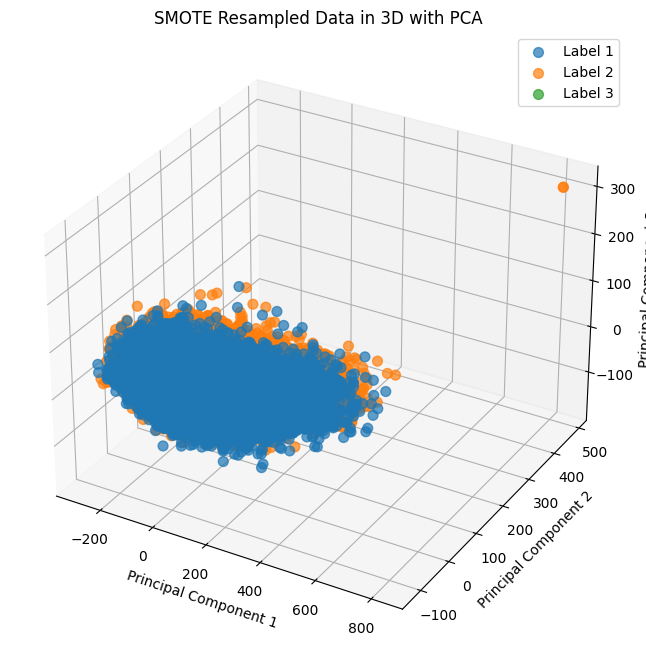

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

# 예시 데이터 생성
X = np.array(train_combined_stfold)  # 예시 데이터 X
y = np.array(mapped_labels)  # 예시 라벨 y

# SMOTE 오버샘플링 적용
smote = SMOTE(sampling_strategy='auto', random_state=0)
X_resampled, y_resampled = smote.fit_resample(X, y) # SMOTE 완

# PCA를 사용하여 데이터를 3차원으로 축소
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_resampled)

# 시각화
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 클래스별로 데이터를 나누어서 산점도로 그리기
for label in np.unique(y_resampled):
    idx = y_resampled == label
    ax.scatter(X_pca[idx, 0], X_pca[idx, 1], X_pca[idx, 2], label=f'Label {label}', s=50, alpha=0.7)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('SMOTE Resampled Data in 3D with PCA')
ax.legend()
plt.show()


In [ ]:
with open('/content/drive/MyDrive/smote_train.pkl', 'wb') as f:
     pickle.dump(X_resampled, f)
with open('/content/drive/MyDrive/smote_label_int.pkl', 'wb') as f:
     pickle.dump(y_resampled, f)

In [ ]:
reverse_mapping = {
    1: [0., 1.],
    2: [1., 0.],
    3: [1., 1.]
}

label_org = np.array([reverse_mapping[label] for label in y_resampled])

In [ ]:
with open('/content/drive/MyDrive/smote_label_arr_final.pkl', 'wb') as f:
     pickle.dump(label_org, f)

In [ ]:
smote_train, smote_val, smote_train_label, smote_val_label = train_test_split(X_resampled, label_org,
                                    test_size=CONFIG.SPLIT_RATE,
                                    random_state=CONFIG.SEED)

In [ ]:
train_dataset = CustomDataset(smote_train, smote_train_label)
val_dataset = CustomDataset(smote_val, smote_val_label)


train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG.BATCH_SIZE,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG.BATCH_SIZE,
    shuffle=False
)

# Model

## MLP_RNN 모델

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim=CONFIG.N_CHROMA+CONFIG.N_MELS+CONFIG.N_MFCC, hidden_dim=512, output_dim=CONFIG.N_CLASSES):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.ln2 = nn.LayerNorm(hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, hidden_dim // 4)
        self.ln3 = nn.LayerNorm(hidden_dim // 4)
        self.fc4 = nn.Linear(hidden_dim // 4, hidden_dim // 8)
        self.ln4 = nn.LayerNorm(hidden_dim // 8)
        self.fc5 = nn.Linear(hidden_dim // 8, hidden_dim // 16)
        self.ln5 = nn.LayerNorm(hidden_dim // 16)
        self.fc6 = nn.Linear(hidden_dim // 16, hidden_dim // 32)
        self.ln6 = nn.LayerNorm(hidden_dim // 32)
        self.fc7 = nn.Linear(hidden_dim // 32, hidden_dim // 64)
        self.ln7 = nn.LayerNorm(hidden_dim // 64)
        self.fc8 = nn.Linear(hidden_dim // 64, hidden_dim // 128)
        self.ln8 = nn.LayerNorm(hidden_dim // 128)
        self.fc9 = nn.Linear(hidden_dim // 128, output_dim)

        self.dropout = nn.Dropout(p=0.5) # ..???? 0.5 가 과연 성능이 좋을지

    def forward(self, x):
        x = self.dropout(F.relu(self.ln1(self.fc1(x))))
        x = self.dropout(F.relu(self.ln2(self.fc2(x))))
        x = self.dropout(F.relu(self.ln3(self.fc3(x))))
        x = self.dropout(F.relu(self.ln4(self.fc4(x))))
        x = self.dropout(F.relu(self.ln5(self.fc5(x))))
        x = self.dropout(F.relu(self.ln6(self.fc6(x))))
        x = self.dropout(F.relu(self.ln7(self.fc7(x))))
        x = self.dropout(F.relu(self.ln8(self.fc8(x))))
        x = self.fc9(x)
        return x

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_dim=CONFIG.N_CHROMA+CONFIG.N_MFCC+CONFIG.N_MELS, hidden_dim=100, output_dim=CONFIG.N_CLASSES, num_layers=2):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Multiply by 2 for bidirectional
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add an extra dimension for batch processing
        x, _ = self.rnn(x)
        x = x[:, -1, :]  # Use the output from the last time step
        x = self.dropout(x)  # Apply dropout
        x = self.fc(x)
        x = torch.sigmoid(x)
        return x


In [ ]:
# RNN ver2.

#

class RNN(nn.Module):
    def __init__(self, input_dim=CONFIG.N_CHROMA+CONFIG.N_MFCC+CONFIG.N_MELS, hidden_dim=128, output_dim=CONFIG.N_CLASSES, num_layers=2):
        super(RNN, self).__init__()
        self.rnn1 = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.rnn2 = nn.LSTM(hidden_dim * 2, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim//2)
        self.fc2 = nn.Linear(hidden_dim//2, hidden_dim//4)
        self.fc3 = nn.Linear(hidden_dim//4, hidden_dim//8)
        self.fc4 = nn.Linear(hidden_dim//8, output_dim)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add an extra dimension for batch processing
        x, _ = self.rnn1(x)
        x, _ = self.rnn2(x)
        x = x[:, -1, :]  # Take the last timestep's output
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        # x = self.dropout(x)
        x = F.relu(self.fc2(x))
        # x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = torch.sigmoid(x)
        return x

In [ ]:
# MLP-RNN 앙상블 모델 정의
class MLP_RNN(nn.Module):
    def __init__(self, mlp_model, rnn_model):
        super(MLP_RNN, self).__init__()
        self.mlp = mlp_model
        self.rnn = rnn_model

    def forward(self, x):
        mlp_out = self.mlp(x)
        mlp_out = torch.sigmoid(mlp_out)

        rnn_out = self.rnn(x)
        rnn_out = torch.sigmoid(rnn_out)
        return mlp_out, rnn_out

# CNN, RNN 앙상블

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_LSTM(nn.Module):
    def __init__(self):
        super(CNN_LSTM, self).__init__()
        self.cnn1 = nn.Conv2d(1, 64, kernel_size=(3, 3), padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))

        self.cnn2 = nn.Conv2d(64, 64, kernel_size=(3, 3), padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.cnn3 = nn.Conv2d(64, 256, kernel_size=(3, 3), padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2))

        # Adjust LSTM input size to match the reshaped tensor
        self.lstm = nn.LSTM(256, 512, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(1024, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.cnn1(x))))
        x = self.pool2(F.relu(self.bn2(self.cnn2(x))))
        x = self.pool3(F.relu(self.bn3(self.cnn3(x))))

        # Reshape x to (batch_size, seq_len, input_size) for LSTM
        x = x.view(x.size(0), -1, x.size(1) * x.size(2))  # reshaping

        x, _ = self.lstm(x)

        x = F.relu(self.fc1(x[:, -1, :]))  # taking only the last timestep output
        x = self.dropout(x)
        x = self.fc2(x)

        return torch.sigmoid(x)

# Set CUDA_LAUNCH_BLOCKING=1 before running the script for more detailed error
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Device setup and running the model
x = torch.randn(1, 1, 12, 1209).to(device)
teacher = CNN_LSTM().to(device)
output = teacher(x)
print(output)


tensor([[0.4947, 0.4936]], device='cuda:0', grad_fn=<SigmoidBackward0>)


## train

In [ ]:
from IPython.display import Audio, display
from sklearn.metrics import roc_auc_score

def play_audio(file_path):
    audio = open(file_path, 'rb').read()
    display(Audio(file_path, autoplay=False))

# AUC 계산 함수 정의
def multiLabel_AUC(y_true, y_scores):
    auc_scores = []
    for i in range(y_true.shape[1]):
        auc = roc_auc_score(y_true[:, i], y_scores[:, i])
        auc_scores.append(auc)
    mean_auc_score = np.mean(auc_scores)
    return mean_auc_score


# 검증 함수 정의
def validation(model, criterion, val_loader, device):
    model.eval()
    val_losses = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for features, labels in val_loader:
            features = features.float()
            features = features.unsqueeze(dim=1).to(device)
            labels = labels.float().to(device)
            # mlp_output, rnn_output = model(features)
            output = model(features).to(device)
            loss = criterion(output, labels)

            val_losses.append(loss.item())

            all_labels.append(labels.cpu().numpy())
            all_probs.append(output.cpu().numpy())  # MLP의 출력만 사용

        avg_val_loss = np.mean(val_losses)
        all_labels = np.concatenate(all_labels, axis=0)
        all_probs = np.concatenate(all_probs, axis=0)

        val_auc = multiLabel_AUC(all_labels, all_probs)

    return avg_val_loss, val_auc

# 학습 함수 정의
def train(model, optimizer, train_loader, val_loader, unlabeled_loader, device):

    criterion = nn.BCELoss().to(device)  # 이진 교차 엔트로피 손실 사용

    best_val_auc = 0
    best_model = None
    best_epoch = -1

    for epoch in range(1, 3):
        model.train()
        train_losses = []

        # Labeled 데이터셋 학습
        for features, labels in tqdm(train_loader):
            features = features.float()
            features = features.unsqueeze(dim=1).to(device)
            # print('\n',features.shape)
            labels = labels.float().to(device)
            optimizer.zero_grad()

            # RNN 만 사용
            output = model(features).float().to(device)
            loss = criterion(output, labels)

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())


        # Validation
        val_loss, val_auc = validation(model, criterion, val_loader, device)
        print(f'Epoch [{epoch}/{CONFIG.N_EPOCHS}], Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}')

        for i in range(30,35):
            print(test.iloc[i]['path'])
            play_audio(test.iloc[i]['path'])
            first_test_features = test_dataset[i]  # unlabeled_dataset에서 첫 번째 데이터 가져오기
            first_test_features = torch.tensor(first_test_features, device=device, dtype=torch.float32).unsqueeze(0)  # 배치 차원 추가
            first_test_features = first_test_features.unsqueeze(dim = 1)
            output = model(first_test_features)
            print(f'MLP output: NONE, RNN output: {output}')
        print("========================================================================================")
            # Select the best model based on validation AUC

        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_model = model
            best_epoch = epoch

    return best_model, epoch

# 모델 및 optimizer 설정
# mlp_model = MLP()
# rnn_model = RNN()
# model = MLP_RNN(mlp_model, rnn_model)

In [ ]:
model = CNN_LSTM().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG.LR)
# 학습 실행
best_model, best_epoch = train(model, optimizer, train_loader, val_loader, unlabeled_loader, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

In [ ]:
# 추가학습 시키고 싶으면 실행


best_model = CNN_LSTM().to(device)
best_model.load_state_dict(torch.load(f"./CNN_LSTM_model_without_unlabeled34epoch.pth")) # 최고 모델 저장했던 path

# model.load_state_dict(best_model.state_dict())  # best_model의 상태를 로드

optimizer = torch.optim.Adam(best_model.parameters(), lr=CONFIG.LR)

# 학습 실행
best_model, best_epoch = train(best_model, optimizer, train_loader, val_loader, unlabeled_loader, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

100%|██████████| 949/949 [02:19<00:00,  6.81it/s]


Epoch [1/30], Train Loss: 0.1022, Val Loss: 0.4251, Val AUC: 0.9543
./test/TEST_00030.ogg


MLP output: NONE, RNN output: tensor([[0.0187, 1.0000]], device='cuda:0', grad_fn=<SigmoidBackward0>)
./test/TEST_00031.ogg


MLP output: NONE, RNN output: tensor([[0.0587, 1.0000]], device='cuda:0', grad_fn=<SigmoidBackward0>)
./test/TEST_00032.ogg


MLP output: NONE, RNN output: tensor([[0.0058, 1.0000]], device='cuda:0', grad_fn=<SigmoidBackward0>)
./test/TEST_00033.ogg


MLP output: NONE, RNN output: tensor([[0.0208, 1.0000]], device='cuda:0', grad_fn=<SigmoidBackward0>)
./test/TEST_00034.ogg


MLP output: NONE, RNN output: tensor([[0.0451, 1.0000]], device='cuda:0', grad_fn=<SigmoidBackward0>)


100%|██████████| 949/949 [02:20<00:00,  6.74it/s]


Epoch [2/30], Train Loss: 0.0500, Val Loss: 0.4244, Val AUC: 0.9522
./test/TEST_00030.ogg


MLP output: NONE, RNN output: tensor([[0.0307, 1.0000]], device='cuda:0', grad_fn=<SigmoidBackward0>)
./test/TEST_00031.ogg


MLP output: NONE, RNN output: tensor([[0.0981, 1.0000]], device='cuda:0', grad_fn=<SigmoidBackward0>)
./test/TEST_00032.ogg


MLP output: NONE, RNN output: tensor([[0.0129, 1.0000]], device='cuda:0', grad_fn=<SigmoidBackward0>)
./test/TEST_00033.ogg


MLP output: NONE, RNN output: tensor([[0.1814, 1.0000]], device='cuda:0', grad_fn=<SigmoidBackward0>)
./test/TEST_00034.ogg


MLP output: NONE, RNN output: tensor([[0.0340, 1.0000]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [ ]:
print(best_epoch)
# fake 인 것만 너무 나와서 수상해서 테스트 데이터셋 넣었을 때 어떻게 나오는지 확인
for i in range(3000,3010):
        print(test.iloc[i]['path'])
        play_audio(test.iloc[i]['path'])
        first_test_features = test_dataset[i]  # unlabeled_dataset에서 첫 번째 데이터 가져오기
        first_test_features = torch.tensor(first_test_features, device=device, dtype=torch.float32).unsqueeze(0)  # 배치 차원 추가
        first_test_features = first_test_features.unsqueeze(dim = 1)
        output = best_model(first_test_features)
        print(f'MLP output: NONE, RNN output: {output}')
        print("========================================================================================")

4
./test/TEST_03000.ogg


MLP output: NONE, RNN output: tensor([[0.0664, 1.0000]], device='cuda:0', grad_fn=<SigmoidBackward0>)
./test/TEST_03001.ogg


MLP output: NONE, RNN output: tensor([[0.1398, 1.0000]], device='cuda:0', grad_fn=<SigmoidBackward0>)
./test/TEST_03002.ogg


MLP output: NONE, RNN output: tensor([[0.7671, 1.0000]], device='cuda:0', grad_fn=<SigmoidBackward0>)
./test/TEST_03003.ogg


MLP output: NONE, RNN output: tensor([[0.0981, 1.0000]], device='cuda:0', grad_fn=<SigmoidBackward0>)
./test/TEST_03004.ogg


MLP output: NONE, RNN output: tensor([[0.7541, 0.9915]], device='cuda:0', grad_fn=<SigmoidBackward0>)
./test/TEST_03005.ogg


MLP output: NONE, RNN output: tensor([[0.0483, 1.0000]], device='cuda:0', grad_fn=<SigmoidBackward0>)
./test/TEST_03006.ogg


MLP output: NONE, RNN output: tensor([[0.6196, 1.0000]], device='cuda:0', grad_fn=<SigmoidBackward0>)
./test/TEST_03007.ogg


MLP output: NONE, RNN output: tensor([[0.0047, 1.0000]], device='cuda:0', grad_fn=<SigmoidBackward0>)
./test/TEST_03008.ogg


MLP output: NONE, RNN output: tensor([[0.6782, 1.0000]], device='cuda:0', grad_fn=<SigmoidBackward0>)
./test/TEST_03009.ogg


MLP output: NONE, RNN output: tensor([[0.0457, 1.0000]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [ ]:
torch.save(best_model.state_dict(), f'./CNN_LSTM_model_without_unlabeled{34+best_epoch}epoch.pth') # 모델 저장 파일명 변경

# UNLABELED 클러스터링

## kmeans, pca

34925
Cluster sizes: [25278  9647]


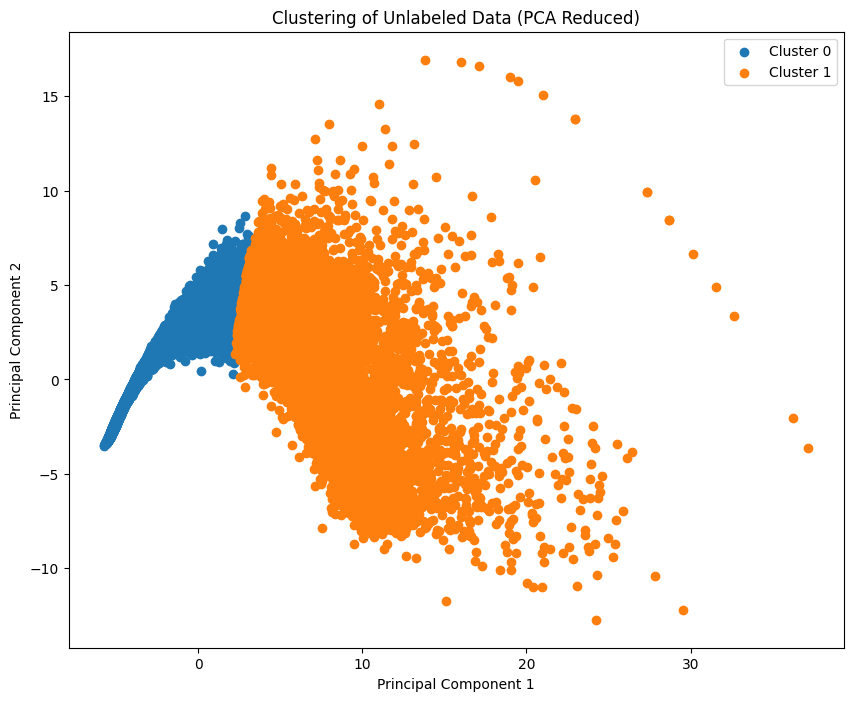

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Assuming unlabeled_dataset is your CustomDataset object

# Convert dataset to numpy array
# unlabeled_data = np.array([sample for sample, _ in unlabeled_dataset])  # Assuming each sample is (12, 1209)

# Reshape the data
num_samples, _, _ = np.array(train_features).shape
print(num_samples)
train_features_reshaped = np.array(train_features).reshape(num_samples, -1)  # Reshape to (num_samples, 12 * 1209)

# Perform PCA for dimensionality reduction (reduce to 50 components)
pca = PCA(n_components=100)  # You can adjust n_components as needed
reduced_data = pca.fit_transform(train_features_reshaped)

# Perform K-means clustering on reduced data
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(reduced_data)

# Analyze the clustering results
cluster_counts = np.bincount(clusters)
print(f"Cluster sizes: {cluster_counts}")

# Optionally, you can visualize the clusters (although in high-dimensional space it's not straightforward)
# For visualization, further dimensionality reduction or clustering evaluation techniques are needed.


# Visualize the clusters
plt.figure(figsize=(10, 8))

for cluster_idx in range(num_clusters):
    cluster_indices = np.where(clusters == cluster_idx)[0]
    plt.scatter(reduced_data[cluster_indices, 0], reduced_data[cluster_indices, 1], label=f'Cluster {cluster_idx}')

plt.title('Clustering of Unlabeled Data (PCA Reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

Cluster sizes: [223 384 563  94]


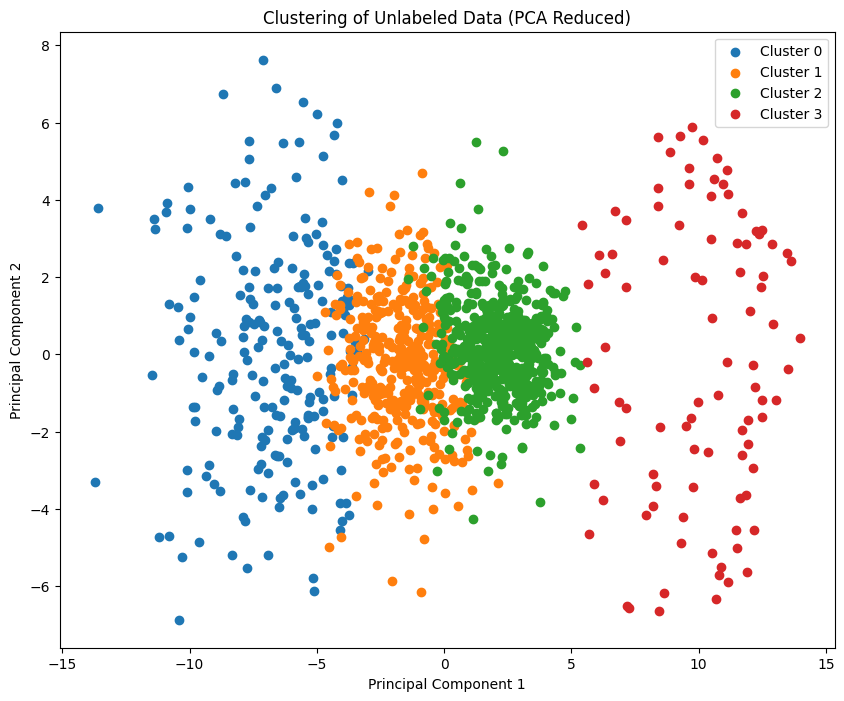

Cluster 0:
 - Index 8: Sample shape (12, 1209)
 - Index 10: Sample shape (12, 1209)
 - Index 11: Sample shape (12, 1209)
 - Index 16: Sample shape (12, 1209)
 - Index 23: Sample shape (12, 1209)
 - Index 25: Sample shape (12, 1209)
 - Index 26: Sample shape (12, 1209)
 - Index 28: Sample shape (12, 1209)
 - Index 33: Sample shape (12, 1209)
 - Index 34: Sample shape (12, 1209)
 - Index 35: Sample shape (12, 1209)
 - Index 48: Sample shape (12, 1209)
 - Index 55: Sample shape (12, 1209)
 - Index 58: Sample shape (12, 1209)
 - Index 66: Sample shape (12, 1209)
 - Index 72: Sample shape (12, 1209)
 - Index 82: Sample shape (12, 1209)
 - Index 101: Sample shape (12, 1209)
 - Index 103: Sample shape (12, 1209)
 - Index 111: Sample shape (12, 1209)
 - Index 123: Sample shape (12, 1209)
 - Index 124: Sample shape (12, 1209)
 - Index 127: Sample shape (12, 1209)
 - Index 130: Sample shape (12, 1209)
 - Index 139: Sample shape (12, 1209)
 - Index 145: Sample shape (12, 1209)
 - Index 149: Sampl

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Assuming unlabeled_dataset is your CustomDataset object

# Convert dataset to numpy array
# unlabeled_data = np.array([sample for sample, _ in unlabeled_dataset])  # Assuming each sample is (12, 1209)

# Reshape the data
num_samples, _, _ = np.array(unlabeled_features).shape
unlabeled_data_reshaped = np.array(unlabeled_features).reshape(num_samples, -1)  # Reshape to (num_samples, 12 * 1209)

# Perform PCA for dimensionality reduction (reduce to 50 components)
pca = PCA(n_components=1200)  # You can adjust n_components as needed
reduced_data = pca.fit_transform(unlabeled_data_reshaped)

# Perform K-means clustering on reduced data
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(reduced_data)

# Analyze the clustering results
cluster_counts = np.bincount(clusters)
print(f"Cluster sizes: {cluster_counts}")

# Optionally, you can visualize the clusters (although in high-dimensional space it's not straightforward)
# For visualization, further dimensionality reduction or clustering evaluation techniques are needed.


# Visualize the clusters
plt.figure(figsize=(10, 8))

for cluster_idx in range(num_clusters):
    cluster_indices = np.where(clusters == cluster_idx)[0]
    plt.scatter(reduced_data[cluster_indices, 0], reduced_data[cluster_indices, 1], label=f'Cluster {cluster_idx}')

cluster_indices = np.where(clusters == cluster_idx)[0]

plt.title('Clustering of Unlabeled Data (PCA Reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# Assume clusters and unlabeled_data are already defined

cluster_list = []

# Iterate over each cluster index
for cluster_idx in range(num_clusters):
    cluster_indices = np.where(clusters == cluster_idx)[0]
    idx_list_per_cluster = []
    print(f"Cluster {cluster_idx}:")
    # Iterate over indices in the current cluster
    for idx in cluster_indices:
        # Get the corresponding sample from unlabeled_data
        sample = unlabeled_features[idx]
        # Perform further analysis or processing with 'sample'
        # Print or use the index 'idx' as needed
        print(f" - Index {idx}: Sample shape {sample.shape}")
        idx_list_per_cluster.append(idx)

    cluster_list.append(idx_list_per_cluster)


In [ ]:
print(len(clusters))

for idx, cluster in enumerate(cluster_list):
    print(idx)
    for idx in cluster[0:10]:
        path = unlabeled_df.iloc[idx]['path']
        print(path, idx)
        play_audio(path)

    print("================================")

1264
0
./unlabeled_data/FVPBUBIT.ogg 8


./unlabeled_data/FWKTHPQA.ogg 10


./unlabeled_data/FWQPUPXG.ogg 11


./unlabeled_data/FYZJFDXG.ogg 16


./unlabeled_data/GAMHXBDV.ogg 23


./unlabeled_data/GDTSIVTW.ogg 25


./unlabeled_data/GEEAAQLZ.ogg 26


./unlabeled_data/GEFIMATF.ogg 28


./unlabeled_data/GJALMXWB.ogg 33


./unlabeled_data/GJCHONJH.ogg 34


1
./unlabeled_data/FTGRTZYC.ogg 5


./unlabeled_data/FUFWSVUM.ogg 6


./unlabeled_data/FUSTRUEP.ogg 7


./unlabeled_data/FXFCMSAD.ogg 12


./unlabeled_data/FYWXJEQP.ogg 14


./unlabeled_data/FZYBTJRP.ogg 20


./unlabeled_data/GDNSJPOL.ogg 24


./unlabeled_data/GEEWJANZ.ogg 27


./unlabeled_data/GHRKKDYK.ogg 32


./unlabeled_data/GNTMYNEJ.ogg 42


2
./unlabeled_data/FNVWSHLS.ogg 0


./unlabeled_data/FPDBVKFE.ogg 1


./unlabeled_data/FQTNHXBZ.ogg 3


./unlabeled_data/FSTFASXM.ogg 4


./unlabeled_data/FWADWDVI.ogg 9


./unlabeled_data/FXIIMURW.ogg 13


./unlabeled_data/FYYGEGUN.ogg 15


./unlabeled_data/FZPVJXJH.ogg 17


./unlabeled_data/FZRFOYKB.ogg 18


./unlabeled_data/FZXLUCUC.ogg 19


3
./unlabeled_data/FPNNRLGQ.ogg 2


./unlabeled_data/GGBRSEZY.ogg 30


./unlabeled_data/GMDMISOJ.ogg 41


./unlabeled_data/GPKUXBMP.ogg 43


./unlabeled_data/GZCQSSDZ.ogg 57


./unlabeled_data/HEWTHZDI.ogg 63


./unlabeled_data/HHBKHMWT.ogg 67


./unlabeled_data/HNIZIBCL.ogg 83


./unlabeled_data/HOTNUVAK.ogg 88


./unlabeled_data/HQPDAWWT.ogg 91


Cluster sizes: [ 5366 24804 13374  6456]


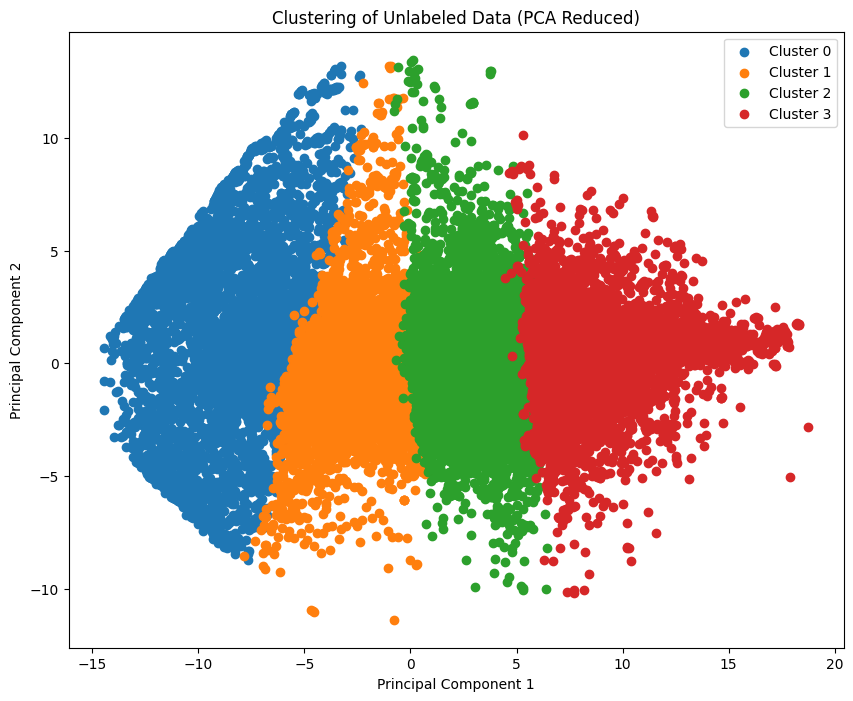

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 - Index 10981: Sample shape (12, 1209)
 - Index 10982: Sample shape (12, 1209)
 - Index 10987: Sample shape (12, 1209)
 - Index 11006: Sample shape (12, 1209)
 - Index 11008: Sample shape (12, 1209)
 - Index 11009: Sample shape (12, 1209)
 - Index 11014: Sample shape (12, 1209)
 - Index 11018: Sample shape (12, 1209)
 - Index 11021: Sample shape (12, 1209)
 - Index 11027: Sample shape (12, 1209)
 - Index 11037: Sample shape (12, 1209)
 - Index 11041: Sample shape (12, 1209)
 - Index 11043: Sample shape (12, 1209)
 - Index 11044: Sample shape (12, 1209)
 - Index 11048: Sample shape (12, 1209)
 - Index 11058: Sample shape (12, 1209)
 - Index 11061: Sample shape (12, 1209)
 - Index 11073: Sample shape (12, 1209)
 - Index 11080: Sample shape (12, 1209)
 - Index 11095: Sample shape (12, 1209)
 - Index 11104: Sample shape (12, 1209)
 - Index 11119: Sample shape (12, 1209)
 - Index 11131: Sample shape (12, 1209)
 - Index 11144: Sample shape (12, 1209)
 - I

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Assuming unlabeled_dataset is your CustomDataset object

# Convert dataset to numpy array
# unlabeled_data = np.array([sample for sample, _ in unlabeled_dataset])  # Assuming each sample is (12, 1209)

# Reshape the data
num_samples, _, _ = np.array(test_features).shape
test_data_reshaped = np.array(test_features).reshape(num_samples, -1)  # Reshape to (num_samples, 12 * 1209)

# Perform PCA for dimensionality reduction (reduce to 50 components)
pca = PCA(n_components=50)  # You can adjust n_components as needed
reduced_data = pca.fit_transform(test_data_reshaped)

# Perform K-means clustering on reduced data
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(reduced_data)

# Analyze the clustering results
cluster_counts = np.bincount(clusters)
print(f"Cluster sizes: {cluster_counts}")

# Optionally, you can visualize the clusters (although in high-dimensional space it's not straightforward)
# For visualization, further dimensionality reduction or clustering evaluation techniques are needed.


# Visualize the clusters
plt.figure(figsize=(10, 8))

for cluster_idx in range(num_clusters):
    cluster_indices = np.where(clusters == cluster_idx)[0]
    plt.scatter(reduced_data[cluster_indices, 0], reduced_data[cluster_indices, 1], label=f'Cluster {cluster_idx}')

cluster_indices = np.where(clusters == cluster_idx)[0]

plt.title('Clustering of Unlabeled Data (PCA Reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# Assume clusters and unlabeled_data are already defined

cluster_list = []

# Iterate over each cluster index
for cluster_idx in range(num_clusters):
    cluster_indices = np.where(clusters == cluster_idx)[0]
    idx_list_per_cluster = []
    print(f"Cluster {cluster_idx}:")
    # Iterate over indices in the current cluster
    for idx in cluster_indices:
        # Get the corresponding sample from unlabeled_data
        sample = test_features[idx]
        # Perform further analysis or processing with 'sample'
        # Print or use the index 'idx' as needed
        print(f" - Index {idx}: Sample shape {sample.shape}")
        idx_list_per_cluster.append(idx)

    cluster_list.append(idx_list_per_cluster)


In [ ]:
print(len(clusters))

for idx, cluster in enumerate(cluster_list):
    print(idx)
    for idx in cluster[0:10]:
        path = test.iloc[idx]['path']
        print(path, idx)
        play_audio(path)

    print("================================")


'''
1. ./test/TEST_00021.ogg 21
2. ./test/TEST_00032.ogg 32
2. ./test/TEST_00075.ogg 75
3. ./test/TEST_00040.ogg 40


'''

50000
0
./test/TEST_00000.ogg 0


./test/TEST_00001.ogg 1


./test/TEST_00002.ogg 2


./test/TEST_00004.ogg 4


./test/TEST_00009.ogg 9


./test/TEST_00010.ogg 10


./test/TEST_00012.ogg 12


./test/TEST_00014.ogg 14


./test/TEST_00019.ogg 19


./test/TEST_00020.ogg 20


1
./test/TEST_00003.ogg 3


./test/TEST_00005.ogg 5


./test/TEST_00006.ogg 6


./test/TEST_00008.ogg 8


./test/TEST_00013.ogg 13


./test/TEST_00015.ogg 15


./test/TEST_00016.ogg 16


./test/TEST_00021.ogg 21


./test/TEST_00030.ogg 30


./test/TEST_00034.ogg 34


2
./test/TEST_00011.ogg 11


./test/TEST_00017.ogg 17


./test/TEST_00022.ogg 22


./test/TEST_00032.ogg 32


./test/TEST_00047.ogg 47


./test/TEST_00049.ogg 49


./test/TEST_00055.ogg 55


./test/TEST_00058.ogg 58


./test/TEST_00070.ogg 70


./test/TEST_00075.ogg 75


3
./test/TEST_00007.ogg 7


./test/TEST_00018.ogg 18


./test/TEST_00027.ogg 27


./test/TEST_00033.ogg 33


./test/TEST_00037.ogg 37


./test/TEST_00040.ogg 40


./test/TEST_00041.ogg 41


./test/TEST_00043.ogg 43


./test/TEST_00082.ogg 82


./test/TEST_00083.ogg 83


## kmeans, pca, Agglomerative Clustering, dbscan

In [ ]:
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from scipy.stats import mode
import matplotlib.pyplot as plt

# Assuming unlabeled_data is your dataset with shape (1264, 12, 1209)
num_samples, _, _ = np.array(test_features).shape
test_data_reshaped = np.array(test_features).reshape(num_samples, -1)

# Perform PCA for dimensionality reduction
pca = PCA(n_components=1200)  # You can adjust n_components as needed
reduced_data = pca.fit_transform(test_data_reshaped)

# Perform K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_clusters = kmeans.fit_predict(reduced_data)

# Perform Agglomerative clustering
agglo = AgglomerativeClustering(n_clusters=4)
agglo_clusters = agglo.fit_predict(reduced_data)

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_clusters = dbscan.fit_predict(reduced_data)

# Handle DBSCAN noise points (labeled as -1) by assigning them to a new cluster
noise_label = np.max(dbscan_clusters) + 1
dbscan_clusters[dbscan_clusters == -1] = noise_label

# Combine the clustering results
all_clusters = np.vstack([kmeans_clusters, agglo_clusters, dbscan_clusters])

# Initialize an array to store the final cluster labels
final_clusters = np.zeros(num_samples, dtype=int)

# Voting mechanism for final cluster assignment
for i in range(num_samples):
    unique_labels, counts = np.unique(all_clusters[:, i], return_counts=True)
    final_clusters[i] = unique_labels[np.argmax(counts)]

# Analyze the final clustering results
cluster_counts = np.bincount(final_clusters)
print(f"Final Cluster sizes: {cluster_counts}")


clusters_list = []
# Visualize the clusters
plt.figure(figsize=(10, 8))
num_final_clusters = len(np.unique(final_clusters))
for cluster_idx in range(num_final_clusters):
    cluster_indices = np.where(final_clusters == cluster_idx)[0]
    idx_list_per_cluster = []

    for idx in cluster_indices:
        # Get the corresponding sample from unlabeled_data
        sample = test_features[idx]
        # Perform further analysis or processing with 'sample'
        # Print or use the index 'idx' as needed
        # print(f" - Index {idx}: Sample shape {sample.shape}")
        idx_list_per_cluster.append(idx)

    clusters_list.append(idx_list_per_cluster)

    plt.scatter(reduced_data[cluster_indices, 0], reduced_data[cluster_indices, 1], label=f'Cluster {cluster_idx}')
plt.title('Ensemble Clustering of Unlabeled Data (PCA Reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


# Function to get indices of points in a specific cluster
def get_cluster_indices(cluster_labels, cluster_idx):
    return np.where(cluster_labels == cluster_idx)[0]

# Example: Get indices of points in cluster 0
cluster_0_indices = get_cluster_indices(final_clusters, 0)
print(f"Indices of points in cluster 0: {cluster_0_indices}")


KeyboardInterrupt: 

In [ ]:
print(len(clusters_list))

for idx, cluster in enumerate(clusters_list):
    print(idx)
    for idx in cluster[0:10]:
        path = test.iloc[idx]['path']
        print(path, idx)
        play_audio(path)

    print("================================")


'''
1. ./test/TEST_00021.ogg 21
2. ./test/TEST_00032.ogg 32
2. ./test/TEST_00075.ogg 75
3. ./test/TEST_00040.ogg 40


'''

4
0
./test/TEST_00000.ogg 0


./test/TEST_00001.ogg 1


./test/TEST_00002.ogg 2


./test/TEST_00003.ogg 3


./test/TEST_00004.ogg 4


./test/TEST_00006.ogg 6


./test/TEST_00007.ogg 7


./test/TEST_00008.ogg 8


./test/TEST_00009.ogg 9


./test/TEST_00010.ogg 10


1
./test/TEST_00005.ogg 5


./test/TEST_00014.ogg 14


./test/TEST_00032.ogg 32


./test/TEST_00044.ogg 44


./test/TEST_00050.ogg 50


./test/TEST_00065.ogg 65


./test/TEST_00100.ogg 100


./test/TEST_00114.ogg 114


./test/TEST_00120.ogg 120


./test/TEST_00128.ogg 128


2
./test/TEST_00627.ogg 627


./test/TEST_00681.ogg 681


./test/TEST_00695.ogg 695


./test/TEST_00878.ogg 878


3
./test/TEST_00083.ogg 83


./test/TEST_00138.ogg 138


./test/TEST_00341.ogg 341


./test/TEST_00536.ogg 536


./test/TEST_01111.ogg 1111


'\n1. ./test/TEST_00021.ogg 21\n2. ./test/TEST_00032.ogg 32\n2. ./test/TEST_00075.ogg 75\n3. ./test/TEST_00040.ogg 40\n\n\n'

In [ ]:
!pip install noisereduce

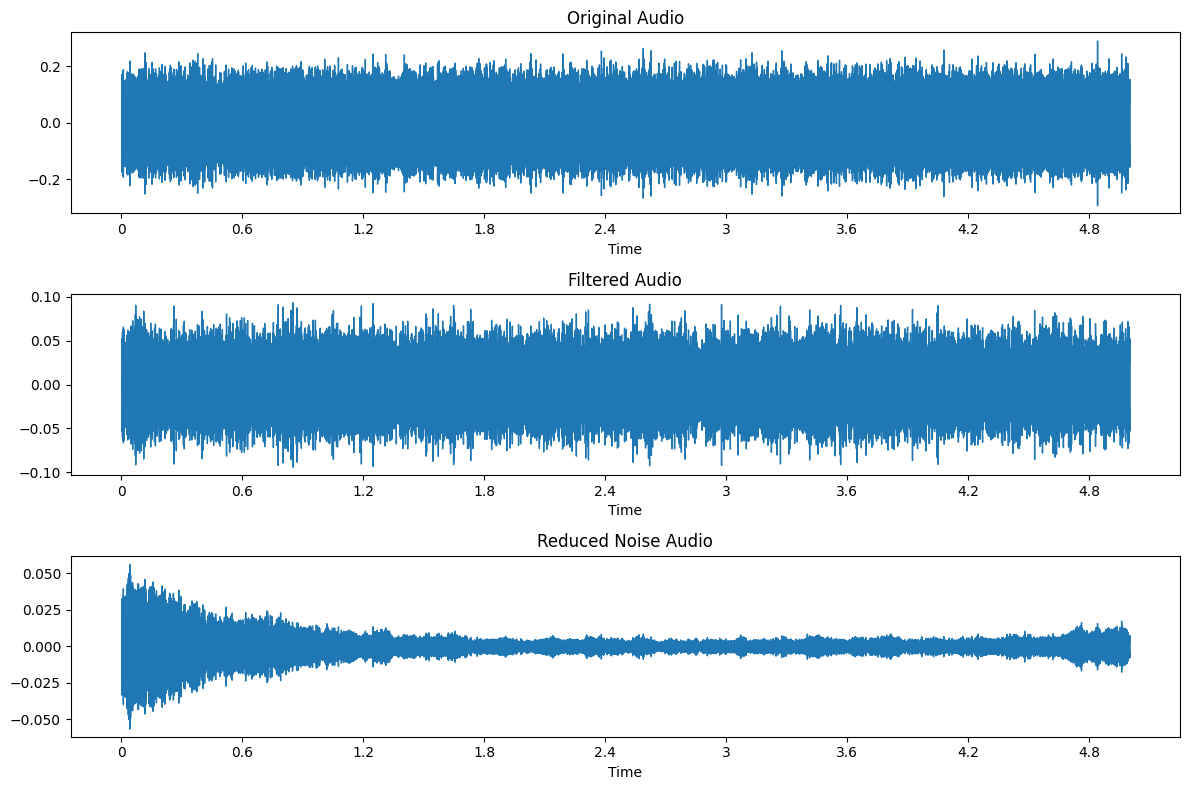

Original Audio:


Filtered Audio:


Reduced Noise Audio:


In [ ]:
import numpy as np
import scipy.signal as signal
import librosa
import matplotlib.pyplot as plt

# 오디오 파일 로드
audio_path = test.iloc[32]['path']
audio, sr = librosa.load(audio_path, sr=None)

# 고역 통과 필터 적용 (주파수 1000Hz 이상 통과)
high_pass_filter = signal.butter(10, 1000, 'hp', fs=sr, output='sos')
filtered_audio_high = signal.sosfilt(high_pass_filter, audio)

# 저역 통과 필터 적용 (주파수 4000Hz 이하 통과)
low_pass_filter = signal.butter(10, 4000, 'lp', fs=sr, output='sos')
filtered_audio_low = signal.sosfilt(low_pass_filter, filtered_audio_high)

# 스펙트럼 게이팅
import noisereduce as nr

# 노이즈 감소
reduced_noise_audio = nr.reduce_noise(y=audio, sr=sr)

# 결과 시각화
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.title('Original Audio')
librosa.display.waveshow(audio, sr=sr)

plt.subplot(3, 1, 2)
plt.title('Filtered Audio')
librosa.display.waveshow(filtered_audio_low, sr=sr)

plt.subplot(3, 1, 3)
plt.title('Reduced Noise Audio')
librosa.display.waveshow(reduced_noise_audio, sr=sr)

plt.tight_layout()
plt.show()

# 오디오 재생
print("Original Audio:")
display(Audio(audio, rate=sr))

print("Filtered Audio:")
display(Audio(filtered_audio_low, rate=sr))

print("Reduced Noise Audio:")
display(Audio(reduced_noise_audio, rate=sr))


# Test

In [ ]:
test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG.BATCH_SIZE,
    shuffle=False
)

# 저장된 모델 불러오기
# model.load_state_dict(torch.load(f"./CNN_LSTM_model_without_unlabeled34epoch.pth"))
model = best_model.to(device)

def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    predictions = []
    with torch.no_grad():
        for features in tqdm(iter(test_loader)):
            features= features.float()
            features = features.unsqueeze(dim=1).to(device)

            output = model(features)

            # MLP의 출력 처리
            probs = torch.sigmoid(output).cpu().detach().numpy()

            # 리스트에 추가
            predictions += probs.tolist()
    return predictions


preds = inference(best_model, test_loader, device)


100%|██████████| 782/782 [00:42<00:00, 18.55it/s]


In [ ]:
print(preds[0:10])
print(best_epoch)

[[0.5388357043266296, 0.7310585379600525], [0.5038111209869385, 0.7310585379600525], [0.5258818864822388, 0.7310584783554077], [0.6395748853683472, 0.7310581207275391], [0.7299498319625854, 0.73101407289505], [0.5019984245300293, 0.7310585379600525], [0.5084409117698669, 0.7310585379600525], [0.5029181241989136, 0.7310584783554077], [0.5020032525062561, 0.7310585379600525], [0.5045469999313354, 0.7310585379600525]]
4


In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/sample_submission.csv')
submit.iloc[:, 1:] = preds
submit.head()
submit.to_csv(f'CNN_LSTM_no_unlabeled_epoch37.csv', index=False) # 저장 파일명 변경